In [2]:
import pandas as pd
import numpy as np
import pyodbc
import seaborn as sns
import matplotlib.pyplot as plt


df=pd.read_csv('bank_marketing.csv')

# splittng the datatable to three relevant tables 
client=df[['client_id', 'age', 'job', 'marital','education', 'credit_default',
       'housing','loan']].copy()
campaign=df[['client_id','campaign','duration','pdays','previous','poutcome','y']].copy()

economics=df[['client_id','emp_var_rate','cons_price_idx','euribor3m','nr_employed']].copy()


#  replacing the columns name with better names 
campaign.loc['campaign_id'] = 1
column_rename_client = {'client_id': 'id'}
column_rename_campaign= {'duration': 'contact_duration', 'previous': 'previous_campaign_contacts', 'y': 'campaign_outcome', 'poutcome': 'previous_outcome', 'campaign': 'number_contacts'}
column_rename_economics = {'euribor3m': 'euribor_three_months','nr_employed': 'number_employed'}

client.rename(columns=column_rename_client, inplace=True)
campaign.rename(columns=column_rename_campaign, inplace=True)
economics.rename(columns=column_rename_economics, inplace=True)


#  cleaning data
client['education'] = client['education'].str.replace('.','_', regex=False)
client['education'] = client['education'].replace('unknown',np.nan, regex=False)
client['job'] = client['job'].str.replace('.', '', regex=False)

outcomes_replace={'success':'1','failure':'0','nonexistent':np.nan }
campaign['previous_outcome'] = campaign['previous_outcome'].replace(outcomes_replace)

#  improving the date column  by converting to the datetime format 
df['year']='2022'
month_mapping = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
                 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}

df['month'] = df['month'].map(month_mapping)
campaign['last_contact_date'] =pd.to_datetime(df[['year', 'month','day']]).dt.strftime('%Y-%m-%d')



#this was done for complete the connection with sql database managment 
# replacing nan values with 2
campaign.previous_outcome.fillna(2, inplace=True)
campaign.drop(campaign.index[-1], inplace=True)

client.to_csv('client.csv', index=False)
campaign.to_csv('campaign.csv', index=False)
economics.to_csv('economics.csv', index=False)


# Define connection parameters
server = 'HUNTER\SQLEXPRESS'
database = 'banks_database'



# Create a connection string
connection_string = (
    f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    f"SERVER={server};"
    f"DATABASE={database};"
    f"Trusted_Connection=yes;"
   
)

# Establish a connection
try:
    conn = pyodbc.connect(connection_string)
    print("Connected to SQL Server")
except Exception as e:
    print(f"Error: {str(e)}")







Connected to SQL Server


In [3]:

# SQL statements for table creation
client_table_sql = """
CREATE TABLE client
(
    id  INT PRIMARY KEY,
    age INT,
    job NVARCHAR(255),
    marital NVARCHAR(255),
    education NVARCHAR(255),
    credit_default NVARCHAR(255),
    housing NVARCHAR(255),
    loan NVARCHAR(255)
);
"""
campaign_table_sql = """
CREATE TABLE campaign (
    campaign_id INT IDENTITY(1,1) PRIMARY KEY,
    client_id INT,
    number_contacts INT,
    contact_duration INT,
    pdays INT,
    previous_campaign_contacts INT,
    previous_outcome INT ,  
    campaign_outcome BIT,
    last_contact_date DATE
);
"""

economics_table_sql = """
CREATE TABLE economics (
    client_id INT REFERENCES client (id),
    emp_var_rate FLOAT,
    cons_price_idx FLOAT,
    euribor_three_months FLOAT,
    number_employed FLOAT
);
"""


try:
    cursor = conn.cursor()
    
    # once you create the tables, no need to run and execute this again      
    # Execute the CREATE TABLE statements
    
    # cursor.execute(client_table_sql)
    # cursor.execute(campaign_table_sql)
    # cursor.execute(economics_table_sql)
    
    print("Tables 'client' and 'campaign' created successfully.")
    
    # Commit the table creation transactions
    conn.commit()
    
except Exception as e:
    print(f"Error: {str(e)}")   



Tables 'client' and 'campaign' created successfully.


In [8]:
# Execute the SQL statements
try:
    cursor = conn.cursor()
    
    # Now, copy data from 'client.csv' and 'campaign.csv'
    copy_data_sql = """
    BULK INSERT client
    FROM 'C:/Users/moham/OneDrive/Desktop/for_now/client.csv'
    WITH (
        FORMAT = 'CSV',
        FIRSTROW = 2,  -- Skip the header row
        FIELDTERMINATOR = ',',
        ROWTERMINATOR = '\n'
    );
    """
    
    
    copy_data_sql1 = """
    BULK INSERT campaign
    FROM 'C:/Users/moham/OneDrive/Desktop/for_now/campaign.csv'
    WITH (
        FORMAT = 'CSV',
        FIRSTROW = 2,  -- Skip the header row
        FIELDTERMINATOR = ',',
        ROWTERMINATOR = '0x0a'
    );
    """
    
    
    
    copy_econimcs_data = """
    BULK INSERT economics
    FROM 'C:/Users/moham/OneDrive/Desktop/for_now/economics.csv'
    WITH (
        FORMAT = 'CSV',
        FIRSTROW = 2,  -- Skip the header row
        FIELDTERMINATOR = ',',
        ROWTERMINATOR = '0x0a'
    );
    """
    
#     cope the data just one time
# no need to copy the same data every time code run
    # Execute the data copy statements
    # cursor.execute(copy_data_sql)
    # cursor.execute(copy_data_sql1)
    # cursor.execute(copy_econimcs_data)
    
    print("Data copied from csv files to sql tables")
    
    
    # Commit the transaction again
    conn.commit()
    
except Exception as e:
    print(f"Error: {str(e)}")

# Close the connection
conn.close()




    






Data copied from csv files to sql tables


In [4]:
# dropping nulls from education column

client.dropna(subset=['education'], inplace=True)
print(f"the number of nan values in education coulmn is {client.education.isna().sum()}")
client.education.unique()

the number of nan values in education coulmn is 0


array(['basic_4y', 'high_school', 'basic_6y', 'basic_9y',
       'professional_course', 'university_degree', 'illiterate'],
      dtype=object)

C:\Users\moham\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\moham\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'with loan'}, xlabel='education', ylabel='count'>

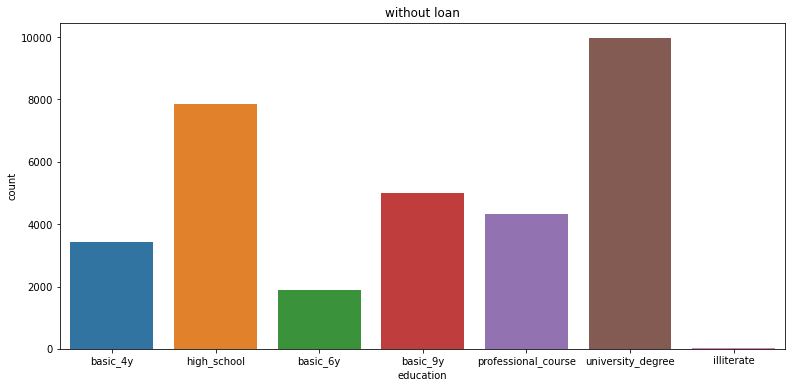

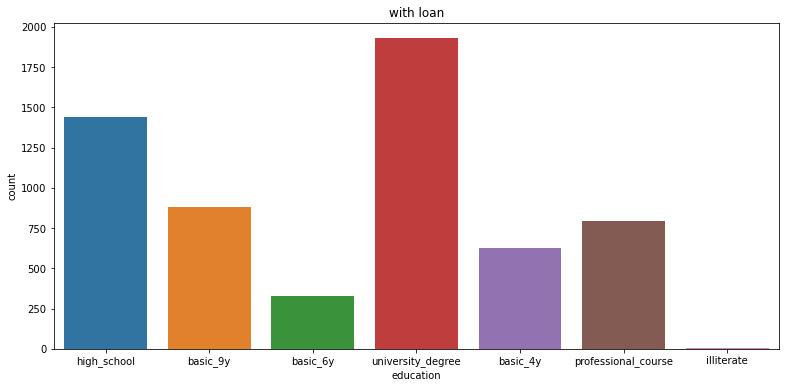

In [12]:
# is there any diffrence in taking loans between poeple with high education and people without it 

with_loan_df= client[client['loan']=='yes']
without_loan_df= client[client['loan']=='no']


plt.figure(figsize=(13, 6))
plt.title('without loan')
sns.countplot(without_loan_df.education)

plt.figure(figsize=(13, 6))
plt.title('with loan')
sns.countplot(with_loan_df.education)


In [13]:
print('with loan')
print(with_loan_df.education.value_counts())
print('without')
print(without_loan_df.education.value_counts())

with loan
university_degree      1930
high_school            1443
basic_9y                883
professional_course     793
basic_4y                624
basic_6y                330
illiterate                3
Name: education, dtype: int64
without
university_degree      9961
high_school            7852
basic_9y               5011
professional_course    4325
basic_4y               3435
basic_6y               1902
illiterate               15
Name: education, dtype: int64


<AxesSubplot:>

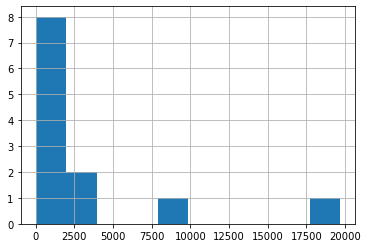

In [25]:
#try to find diffrence in taking loans between the different marital stuatus
#maybe the marries poeple take more loans than sinf
by_marital=client.groupby('marital').loan.value_counts()
by_marital.hist()